In [1]:
!pip install -r /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/requirements.txt


Defaulting to user installation because normal site-packages is not writeable


In [2]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchaudio==0.13.0+cu117 --index-url https://download.pytorch.org/whl/cu117


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-1.13.0%2Bcu117-cp310-cp310-linux_x86_64.whl (1806.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 1.6.1 requires torch>=2.0.0, but you have torch 1.13.0+cu117 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append('/mnt/c/Users/santhosh/Downloads/MedMamba-main')


In [3]:
import importlib.util
import sys

module_name = 'MedMamba'
module_path = r'/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/MedMamba.py'

spec = importlib.util.spec_from_file_location(module_name, module_path)
medmamba = importlib.util.module_from_spec(spec)
sys.modules[module_name] = medmamba
spec.loader.exec_module(medmamba)

/home/santhosh/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 6])


In [7]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
from MedMamba import VSSM as medmamba  # Import MedMamba model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split, DataLoader
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training"
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Split dataset into Train, Validation, and Test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Save test dataset for later use

# Combined Model
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        self.efficient_net.classifier = nn.Identity()

        self.medmamba_model = medmamba(num_classes=num_classes)

        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # Added batch normalization
            nn.Dropout(0.6),  # Increased dropout
            nn.Linear(512, 256),  # Added another fully connected layer
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),  # Additional dropout for better regularization
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1)
        return self.classifier(combined_out)

# Training Function
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")

    batch_size = 8
    num_classes = len(dataset.classes)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    net = CombinedModel(num_classes=num_classes).to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.5, verbose=True)

    precision_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    early_stop_patience = 6
    no_improvement_epochs = 0
    epochs = 100
    best_acc = 0.0
    save_path = 'EfficientMedMambaNet3.pth'
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_correct = 0
        total_train_samples = 0
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        
        for images, labels in tqdm(train_loader, file=sys.stdout, desc=f"Epoch [{epoch+1}/{epochs}] Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
            optimizer.step()
            
            running_loss += loss.item()
            predicted = torch.max(outputs, dim=1)[1]
            train_correct += torch.eq(predicted, labels).sum().item()
            total_train_samples += labels.size(0)
            
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)
            f1_metric.update(predicted, labels)
        
        train_accuracy = train_correct / total_train_samples
        train_loss = running_loss / len(train_loader)
        train_precision = precision_metric.compute().item()
        train_recall = recall_metric.compute().item()
        train_f1 = f1_metric.compute().item()
        
        net.eval()
        val_loss = 0.0
        val_correct = 0
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, file=sys.stdout, desc=f"Epoch [{epoch+1}/{epochs}] Val"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = net(val_images)
                loss = loss_function(outputs, val_labels)
                val_loss += loss.item()
                
                predicted_val = torch.max(outputs, dim=1)[1]
                val_correct += torch.eq(predicted_val, val_labels).sum().item()
                
                precision_metric.update(predicted_val, val_labels)
                recall_metric.update(predicted_val, val_labels)
                f1_metric.update(predicted_val, val_labels)
                
        val_accuracy = val_correct / len(val_dataset)
        val_loss /= len(val_loader)
        val_precision = precision_metric.compute().item()
        val_recall = recall_metric.compute().item()
        val_f1 = f1_metric.compute().item()
        
        print(f"\n[Epoch {epoch+1}]\n"
              f"Train   -> Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, Prec: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}\n"
              f"Val     -> Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}, Prec: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n")

        scheduler.step(val_accuracy)
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            no_improvement_epochs = 0
            torch.save(net.state_dict(), save_path)
        else:
            no_improvement_epochs += 1
        
        if no_improvement_epochs >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation accuracy.")
            break
    
    print("Finished Training")

if __name__ == '__main__':
    main()

Using cuda:0 device.
Epoch [1/100] Val: 100%|██████████| 69/69 [00:13<00:00,  5.24it/s]

[Epoch 1]
Train   -> Loss: 1.1467, Acc: 0.5580, Prec: 0.3647, Recall: 0.3607, F1: 0.3591
Val     -> Loss: 0.7282, Acc: 0.7482, Prec: 0.4068, Recall: 0.4253, F1: 0.4050

Epoch [2/100] Val: 100%|██████████| 69/69 [00:13<00:00,  5.16it/s]

[Epoch 2]
Train   -> Loss: 0.8161, Acc: 0.7163, Prec: 0.4837, Recall: 0.4464, F1: 0.4465
Val     -> Loss: 0.6052, Acc: 0.7920, Prec: 0.6170, Recall: 0.5194, F1: 0.5274

Epoch [3/100] Val: 100%|██████████| 69/69 [00:13<00:00,  5.21it/s]

[Epoch 3]
Train   -> Loss: 0.7118, Acc: 0.7526, Prec: 0.5653, Recall: 0.5060, F1: 0.5177
Val     -> Loss: 0.5818, Acc: 0.8084, Prec: 0.6531, Recall: 0.6040, F1: 0.6052

Epoch [4/100] Val: 100%|██████████| 69/69 [00:12<00:00,  5.47it/s]

[Epoch 4]
Train   -> Loss: 0.6510, Acc: 0.7745, Prec: 0.6024, Recall: 0.5521, F1: 0.5640
Val     -> Loss: 0.5197, Acc: 0.8303, Prec: 0.7075, Recall: 0.6554, F1: 0.6723

Epoch [5/100] Val: 100%|███████

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from tqdm import tqdm
from MedMamba import VSSM as medmamba  # Import MedMamba model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split, DataLoader
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training"
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Training Function
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} device.")

    batch_size = 8
    num_classes = len(dataset.classes)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    net = CombinedModel(num_classes=num_classes).to(device)
    
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, factor=0.5, verbose=True)

    precision_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    early_stop_patience = 6
    no_improvement_epochs = 0
    epochs = 100
    best_acc = 0.0
    save_path = 'EfficientMedMambaNet3.pth'
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        train_correct = 0
        total_train_samples = 0
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        
        for images, labels in tqdm(train_loader, file=sys.stdout, desc=f"Epoch [{epoch+1}/{epochs}] Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)
            optimizer.step()
            
            running_loss += loss.item()
            predicted = torch.max(outputs, dim=1)[1]
            train_correct += torch.eq(predicted, labels).sum().item()
            total_train_samples += labels.size(0)
            
            precision_metric.update(predicted, labels)
            recall_metric.update(predicted, labels)
            f1_metric.update(predicted, labels)
        
        train_accuracy = train_correct / total_train_samples
        train_loss = running_loss / len(train_loader)
        train_precision = precision_metric.compute().item()
        train_recall = recall_metric.compute().item()
        train_f1 = f1_metric.compute().item()
        
        net.eval()
        val_loss = 0.0
        val_correct = 0
        precision_metric.reset()
        recall_metric.reset()
        f1_metric.reset()
        
        with torch.no_grad():
            for val_images, val_labels in tqdm(val_loader, file=sys.stdout, desc=f"Epoch [{epoch+1}/{epochs}] Val"):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = net(val_images)
                loss = loss_function(outputs, val_labels)
                val_loss += loss.item()
                
                predicted_val = torch.max(outputs, dim=1)[1]
                val_correct += torch.eq(predicted_val, val_labels).sum().item()
                
                precision_metric.update(predicted_val, val_labels)
                recall_metric.update(predicted_val, val_labels)
                f1_metric.update(predicted_val, val_labels)
                
        val_accuracy = val_correct / len(val_dataset)
        val_loss /= len(val_loader)
        val_precision = precision_metric.compute().item()
        val_recall = recall_metric.compute().item()
        val_f1 = f1_metric.compute().item()
        
        print(f"\n[Epoch {epoch+1}]\n"
              f"Train   -> Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, Prec: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}\n"
              f"Val     -> Loss: {val_loss:.4f}, Acc: {val_accuracy:.4f}, Prec: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}\n")

        scheduler.step(val_accuracy)
        
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            no_improvement_epochs = 0
            torch.save(net.state_dict(), save_path)
        else:
            no_improvement_epochs += 1
        
        if no_improvement_epochs >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation accuracy.")
            break
    
    print("Finished Training")

if __name__ == '__main__':
    main()


/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/santhosh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] - Train Loss: 57.5374, Train Acc: 74.25% | Val Loss: 12.3536, Val Acc: 80.44%
Model saved!


KeyboardInterrupt: 

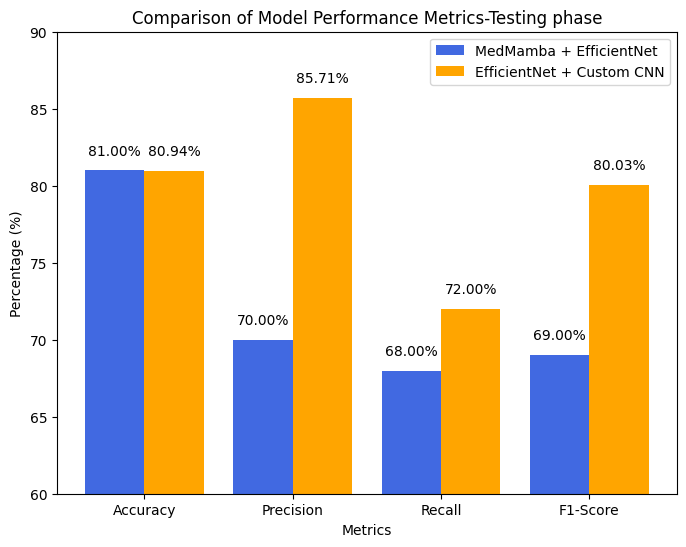

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics and their values
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Values (Converted to Percentage)
medmamba_values = [81, 70, 68, 69]  # MedMamba with EfficientNet
efficientnet_custom_values = [80.94, 85.71, 72.00, 80.03]  # EfficientNet with Custom CNN

# Bar width
bar_width = 0.4
x = np.arange(len(metrics))

# Create Bar Chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x - bar_width/2, medmamba_values, bar_width, label="MedMamba + EfficientNet", color="royalblue")
ax.bar(x + bar_width/2, efficientnet_custom_values, bar_width, label="EfficientNet + Custom CNN", color="orange")

# Labels and Title
ax.set_xlabel("Metrics")
ax.set_ylabel("Percentage (%)")
ax.set_title("Comparison of Model Performance Metrics-Testing phase")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show values on bars
for i, v in enumerate(medmamba_values):
    ax.text(i - bar_width/2, v + 1, f"{v:.2f}%", ha="center", fontsize=10)
for i, v in enumerate(efficientnet_custom_values):
    ax.text(i + bar_width/2, v + 1, f"{v:.2f}%", ha="center", fontsize=10)

# Show plot
plt.ylim(60, 90)
plt.show()



In [4]:
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from MedMamba import VSSM as medmamba  # Import your MedMamba model

# Load full dataset
dataset = datasets.ImageFolder(root="/mnt/c/Users/santhosh/Downloads/MedMamba-main/training", transform=data_transform)



# Get number of classes
num_classes = len(dataset.classes)
class_names = dataset.classes

# Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        # Load Pretrained EfficientNetB0
        self.efficient_net = models.efficientnet_b0(pretrained=True)
        
        # Remove the final classification layer
        self.efficient_net.classifier = nn.Identity()
        
        # Load Medmamba Model
        self.medmamba_model = medmamba(num_classes=num_classes)

        # Define a new classifier combining both models
        self.classifier = nn.Sequential(
            nn.Linear(1000 + 285, 512),  # Combining EfficientNet & Medmamba outputs
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        eff_out = self.efficient_net(x)
        med_out = self.medmamba_model(x)
        combined_out = torch.cat((eff_out, med_out), dim=1) 

        return self.classifier(combined_out)


# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = CombinedModel(num_classes=num_classes)  # Use correct number of classes
model.load_state_dict(torch.load("/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/EfficientMedMambaNet3.pth"))
model.to(device)
model.eval()
test_loader=DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

In [5]:
# Compute testing Accuracy
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:  # Use test_loader instead of test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        
        # Update total and correct counts
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

# Compute accuracy
test_accuracy = 100 * test_correct / test_total
print(f"testing Accuracy: {test_accuracy:.2f}%")


testing Accuracy: 78.96%


In [5]:
import numpy as np

# Initialize metrics
all_labels = []
all_preds = []
total_loss = 0.0
loss_function = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Compute loss
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        # Get predictions
        preds = torch.max(outputs, dim=1)[1]
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute accuracy
accuracy = np.mean(all_preds == all_labels)

# Compute precision, recall, F1-score for each class
precision = precision_score(all_labels, all_preds, average=None, labels=range(num_classes))
recall = recall_score(all_labels, all_preds, average=None, labels=range(num_classes))
f1 = f1_score(all_labels, all_preds, average=None, labels=range(num_classes))

# Compute overall metrics (macro-average)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

print(f"Test Loss: {total_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (per class): {precision}")
print(f"Recall (per class): {recall}")
print(f"F1-score (per class): {f1}")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"F1-score (macro): {f1_macro:.4f}")

Test Loss: 0.7587
Test Accuracy: 77.87%
Precision (per class): [0.38297872 0.68       0.97206704 0.66666667 0.5625    ]
Recall (per class): [0.6        0.72340426 0.94565217 0.51612903 0.33333333]
F1-score (per class): [0.46753247 0.70103093 0.95867769 0.58181818 0.41860465]
Precision (macro): 0.6528
Recall (macro): 0.6237
F1-score (macro): 0.6255


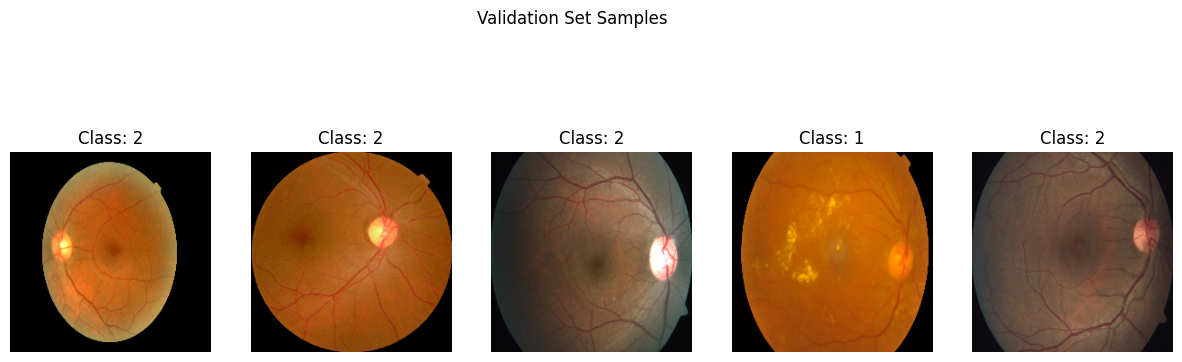

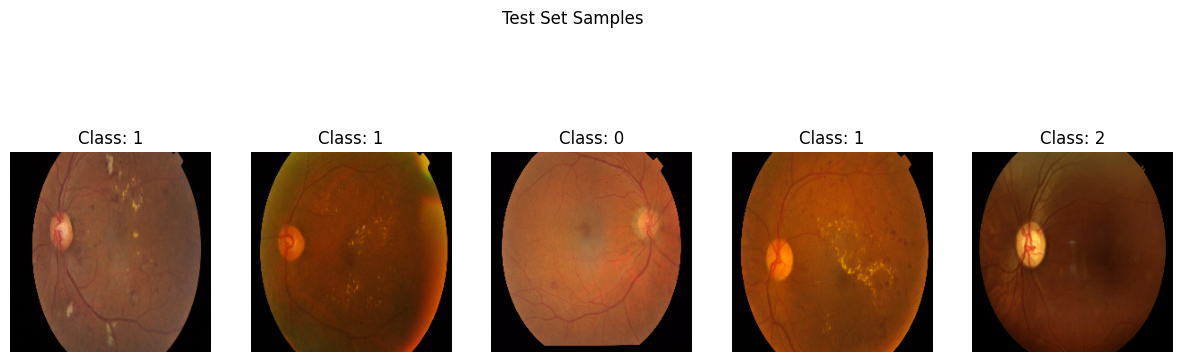

In [48]:
import matplotlib.pyplot as plt
import random

# Function to visualize random images from a dataset
def visualize_images(dataset, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0)  # Convert to (H, W, C)
        axes[i].imshow((image * 0.5) + 0.5)  # Undo normalization
        axes[i].set_title(f"Class: {label}")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# Visualize validation and test images
visualize_images(val_dataset, "Validation Set Samples")
visualize_images(test_dataset, "Test Set Samples")


In [49]:
import torch.nn.functional as F
import numpy as np

def get_confidence_scores(dataloader, model):
    model.eval()
    all_confidences = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
            max_probs, _ = torch.max(probs, dim=1)  # Get highest confidence per prediction
            all_confidences.extend(max_probs.cpu().numpy())

    return np.mean(all_confidences)  # Return average confidence score

val_confidence = get_confidence_scores(val_loader, model)
test_confidence = get_confidence_scores(test_loader, model)

print(f"Validation Confidence Score: {val_confidence:.4f}")
print(f"Test Confidence Score: {test_confidence:.4f}")


Validation Confidence Score: 0.9831
Test Confidence Score: 0.9756


In [50]:
import matplotlib.pyplot as plt

# Assuming you store the history from training
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


NameError: name 'train_losses' is not defined

In [35]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score

# Initialize metrics
all_labels = []
all_preds = []
total_loss = 0.0

# Define loss function
loss_function = torch.nn.CrossEntropyLoss()

# Set model to evaluation mode
model.eval()

# Disable gradient calculation for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = loss_function(outputs, labels)
        total_loss += loss.item()
        
        # Get predicted class
        preds = torch.argmax(outputs, dim=1)
        
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute test accuracy
test_accuracy = accuracy_score(all_labels, all_preds) * 100

# Print test accuracy
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 93.99%


In [25]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt  # Importing matplotlib to show the image

# Function to load and predict
def predict_image_class(image_path, model, device):
    # Load the image
    img = Image.open(image_path)
    
    # Define the same transformations as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # Apply transformations
    image = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Ensure the model is on the same device as the input
    model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)  # Get the predicted class
    
    # Define your class labels
    predictions = ["Mild", "Moderate", "NO_DR", "Proliferate_DR", "Severe"]
    
    # Get the predicted class
    predicted_class = predictions[pred.item()]

    # Display the image with the prediction
    plt.imshow(img)
    plt.axis('off')  # Turn off the axis
    plt.title(f"Prediction: {predicted_class}")
    plt.show()

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

# Get the device (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

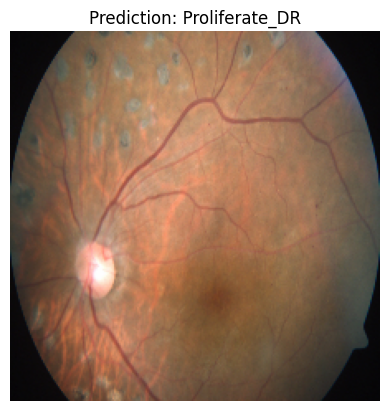

Predicted class: Proliferate_DR


In [26]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/2fe06bedb2c4.png' # Replace with your image path
predict_image_class(image_path, model, device)

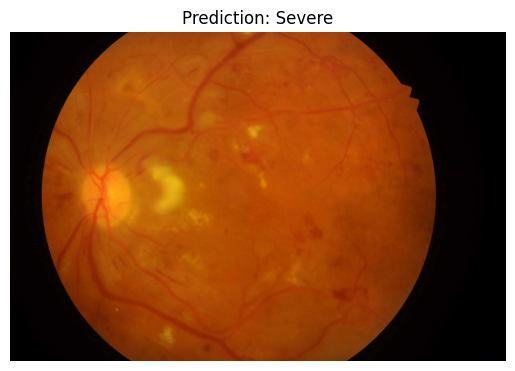

Predicted class: Severe


In [27]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/image (1).jpg' # Replace with your image path
predict_image_class(image_path, model, device)

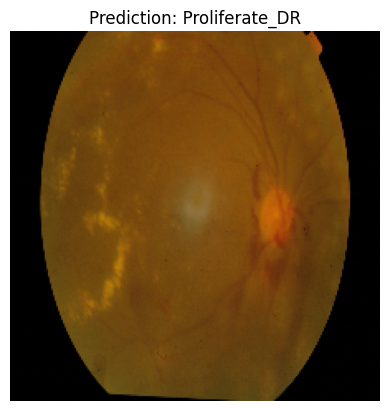

Predicted class: Proliferate_DR


In [28]:
image_path = '/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1b32e1d775ea.png' # Replace with your image path
predict_image_class(image_path, model, device)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from MedMamba import VSSM as medmamba  # Import your MedMamba model

# Define transformations
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define Class Names (Update Based on Your Dataset)
class_names = ["Mild DR", "Moderate DR","No DR","Proliferative DR", "Severe DR"]


# Define Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, class_idx):
        grads = self.gradients
        pooled_grads = torch.mean(grads, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_grads[i]
        heatmap = torch.mean(self.activation, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        return heatmap.cpu().detach().numpy()



# Attach Grad-CAM to EfficientNet last convolutional layer
gradcam = GradCAM(model.efficient_net.features[-1], model.efficient_net.features[-1][0])

# Function to predict class and explain decision
def predict_and_explain(image_path, model, gradcam):
    image = Image.open(image_path).convert("RGB")
    input_tensor = data_transform(image).unsqueeze(0).to(device)

    # Forward pass
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = class_names[predicted_class]

    # Generate Grad-CAM heatmap
    output[:, predicted_class].backward()
    heatmap = gradcam.generate_cam(predicted_class)
    heatmap = cv2.resize(heatmap, (224, 224))

    # Convert PIL image to numpy array
    image_np = np.array(image.resize((224, 224)))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(heatmap)
    ax[1].set_title("Grad-CAM Heatmap")
    ax[2].imshow(overlay)
    ax[2].set_title(f"Overlay - {class_name}")
    plt.show()

    # Generate textual explanation based on Grad-CAM heatmap
    explanation = f"The image is classified as '{class_name}' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision."

    if predicted_class == 0:
        explanation += " There are no significant abnormalities in the fundus image, suggesting a healthy retina. The model focused on the overall uniform texture of the retina."
    elif predicted_class == 1:
        explanation += " The model detected mild signs of diabetic retinopathy, such as small microaneurysms. The highlighted regions correspond to areas where these features are visible."
    elif predicted_class == 2:
        explanation += " Moderate diabetic retinopathy was identified, characterized by more widespread microaneurysms and hemorrhages. The heatmap highlights regions with these abnormalities."
    elif predicted_class == 3:
        explanation += " The model observed severe DR indicators, including larger hemorrhages and exudates. The highlighted areas correspond to these larger, more prominent features."
    elif predicted_class == 4:
        explanation += " Proliferative diabetic retinopathy was detected, with abnormal blood vessel growth and high-risk lesions. The highlighted regions reflect these dangerous features."

    print("\nPrediction:", class_name)
    print("Explanation:", explanation)




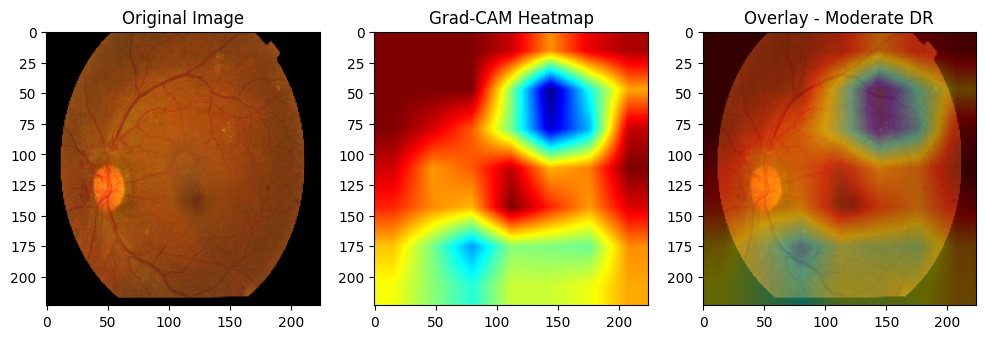


Prediction: Moderate DR
Explanation: The image is classified as 'Moderate DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. The model detected mild signs of diabetic retinopathy, such as small microaneurysms. The highlighted regions correspond to areas where these features are visible.


In [ ]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/1fd5d860d4d7.png"
predict_and_explain(image_path, model, gradcam)

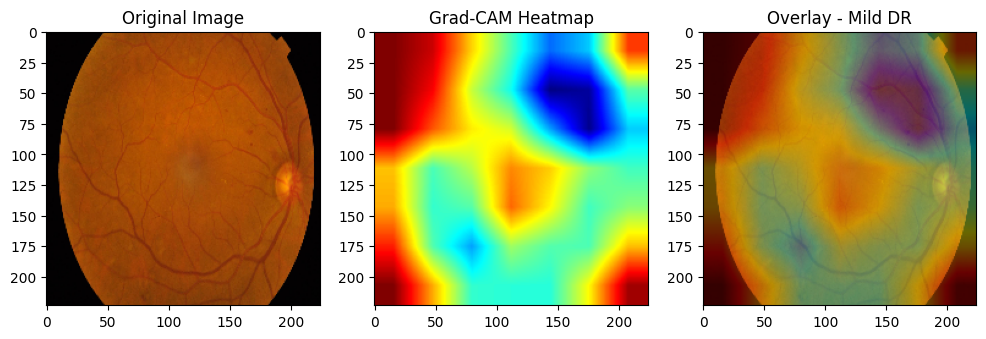


Prediction: Mild DR
Explanation: The image is classified as 'Mild DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. There are no significant abnormalities in the fundus image, suggesting a healthy retina. The model focused on the overall uniform texture of the retina.


In [49]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Mild/1df3e03a8f5f.png"
predict_and_explain(image_path, model, gradcam)

/home/santhosh/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


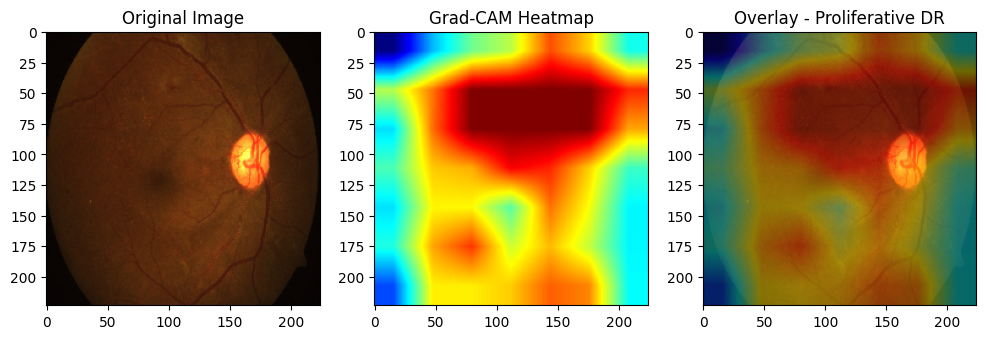


Prediction: Proliferative DR
Explanation: The image is classified as 'Proliferative DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. The model observed severe DR indicators, including larger hemorrhages and exudates. The highlighted areas correspond to these larger, more prominent features.


In [4]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/training/Proliferate_DR/03a7f4a5786f.png"
predict_and_explain(image_path, model, gradcam)

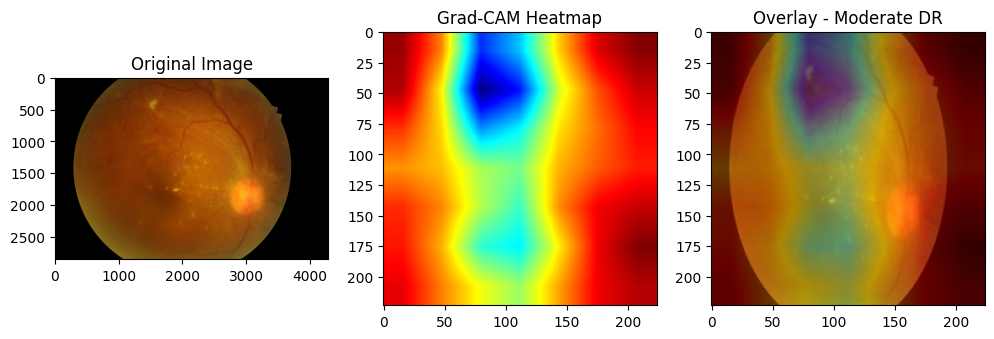


Prediction: Moderate DR
Explanation: The image is classified as 'Moderate DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. The model detected mild signs of diabetic retinopathy, such as small microaneurysms. The highlighted regions correspond to areas where these features are visible.


In [6]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/test-pr.jpg"
predict_and_explain(image_path, model, gradcam)

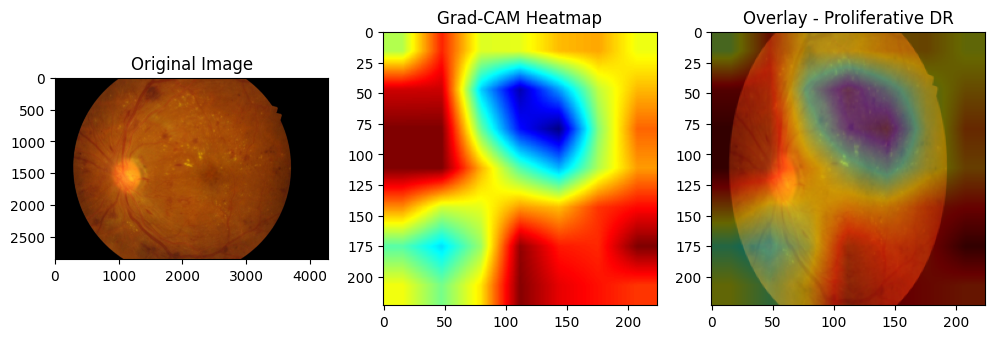


Prediction: Proliferative DR
Explanation: The image is classified as 'Proliferative DR' because the model detected features associated with this condition in the highlighted regions (shown in the heatmap). These regions indicate areas of interest that influenced the model's decision. The model observed severe DR indicators, including larger hemorrhages and exudates. The highlighted areas correspond to these larger, more prominent features.


In [8]:
image_path = "/mnt/c/Users/santhosh/Downloads/MedMamba-main/test-pr1.jpg"
predict_and_explain(image_path, model, gradcam)

In [50]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Calculate Training Accuracy
train_accuracy = evaluate_model(model, train_loader, device)
print(f"Training Accuracy: {train_accuracy:.2f}%")


Training Accuracy: 91.44%


In [51]:
criterion = nn.CrossEntropyLoss() 
def compute_loss(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need for gradient calculation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute batch loss
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples  # Compute average loss
    return avg_loss

# Compute Training Loss
train_loss = compute_loss(model, train_loader, criterion, device)
print(f"Training Loss: {train_loss:.4f}")


Training Loss: 0.2634


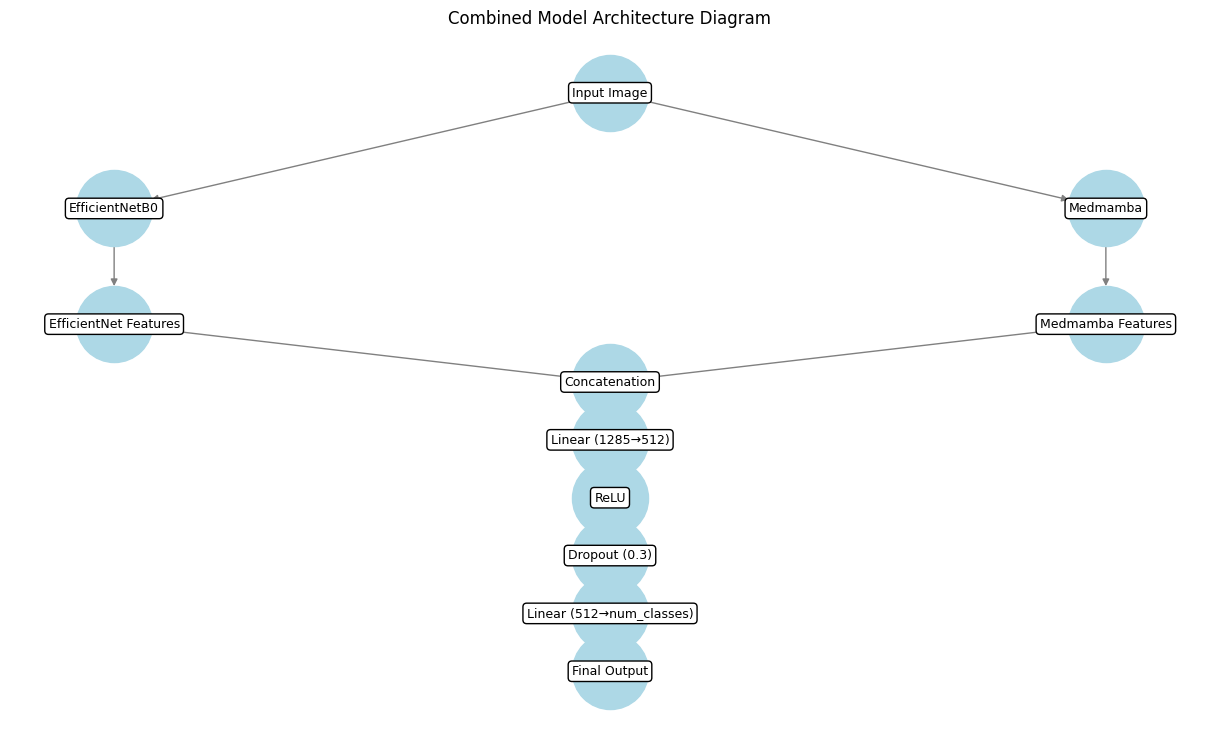

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_model_architecture():
    G = nx.DiGraph()

    # Define edges
    edges = [
        ("Input Image", "EfficientNetB0"),
        ("Input Image", "Medmamba"),
        ("EfficientNetB0", "EfficientNet Features"),
        ("Medmamba", "Medmamba Features"),
        ("EfficientNet Features", "Concatenation"),
        ("Medmamba Features", "Concatenation"),
        ("Concatenation", "Linear (1285→512)"),
        ("Linear (1285→512)", "ReLU"),
        ("ReLU", "Dropout (0.3)"),
        ("Dropout (0.3)", "Linear (512→num_classes)"),
        ("Linear (512→num_classes)", "Final Output")
    ]
    
    G.add_edges_from(edges)
    
    # Define node positions manually for a top-to-bottom flow
    pos = {
        "Input Image": (0, 5),
        "EfficientNetB0": (-1, 4),
        "Medmamba": (1, 4),
        "EfficientNet Features": (-1, 3),
        "Medmamba Features": (1, 3),
        "Concatenation": (0, 2.5),
        "Linear (1285→512)": (0, 2),
        "ReLU": (0, 1.5),
        "Dropout (0.3)": (0, 1),
        "Linear (512→num_classes)": (0, 0.5),
        "Final Output": (0, 0)
    }
    
    plt.figure(figsize=(12, 7))
    nx.draw(G, pos, with_labels=False, node_size=3000, node_color="lightblue", edge_color="gray")
    
    # Draw labels with bounding boxes
    labels = {node: node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=9, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))
    
    plt.title("Combined Model Architecture Diagram")
    plt.show()

# Call function to draw
draw_model_architecture()

In [2]:
!sudo apt install texlive-latex-extra texlive-fonts-recommended dvipng

[sudo] password for santhosh: 


In [4]:
!git clone https://github.com/HarisIqbal88/PlotNeuralNet.git
!cd PlotNeuralNet

Cloning into 'PlotNeuralNet'...


remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 300 (delta 81), reused 72 (delta 72), pack-reused 194 (from 1)
Receiving objects: 100% (300/300), 2.28 MiB | 499.00 KiB/s, done.
Resolving deltas: 100% (136/136), done.


In [17]:
!cd PlotNeuralNet
!python3 examples/alexnet.py

python3: can't open file '/mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/examples/alexnet.py': [Errno 2] No such file or directory


In [27]:
ls /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/PlotNeuralNet/examples/AlexNet

alexnet.pdf*  alexnet.tex*  alexnet_data.png*


In [30]:
!xdg-open /mnt/c/Users/santhosh/Downloads/MedMamba-main/MedMamba-main/PlotNeuralNet/examples/AlexNet/alexnet.pdf

Try running the update-desktop-database command. If you
don't have this command you should install the
desktop-file-utils package. This package is available from
http://freedesktop.org/wiki/Software/desktop-file-utils/
No applications found for mimetype: application/pdf
./bin/xdg-open: 882: x-www-browser: not found
/bin/xdg-open: 882: firefox: not found
/bin/xdg-open: 882: iceweasel: not found
/bin/xdg-open: 882: seamonkey: not found
/bin/xdg-open: 882: mozilla: not found
/bin/xdg-open: 882: epiphany: not found
/bin/xdg-open: 882: konqueror: not found
/bin/xdg-open: 882: chromium: not found
/bin/xdg-open: 882: chromium-browser: not found
/bin/xdg-open: 882: google-chrome: not found
/bin/xdg-open: 882: www-browser: not found
/bin/xdg-open: 882: links2: not found
/bin/xdg-open: 882: elinks: not found
/bin/xdg-open: 882: links: not found
/bin/xdg-open: 882: lynx: not found
/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/mnt/c/Users/santhosh/Downloads/MedMamb

In [32]:
!export PYTHONPATH=$(pwd)/pycore:$PYTHONPATH


In [33]:
import sys
sys.path.append('./src')  # Ensure the source path is available

from pycore.tikzeng import *

# Define the architecture
arch = [
    # Input Image
    to_input('input.png', width=8, height=8, name='input'),

    # EfficientNetB0 Feature Extractor (Pretrained on ImageNet)
    to_ConvConvRelu(name='effnet_b0', s_filer=224, n_filer=(32, 64), offset="(0,0,0)", 
                    to="(input-east)", width=(2,2), height=40, depth=40, caption="EfficientNetB0"),
    
    # Global Feature Extraction (Flattening)
    to_FullyConnected(name="flatten", s_filer=1, n_filer=1024, offset="(1,0,0)", 
                      to="(effnet_b0-east)", width=1, height=3, depth=3, caption="Flatten"),

    # Dense Layer with 5 Output Classes
    to_FullyConnected(name="fc1", s_filer=1, n_filer=5, offset="(1,0,0)", 
                      to="(flatten-east)", width=1, height=2, depth=2, caption="Dense Layer (Softmax)"),

    # Output Layer
    to_SoftMax(name="softmax", n_filer=5, offset="(1,0,0)", to="(fc1-east)", 
               width=1, height=2, depth=2, caption="Output (5 Classes)"),

    to_end()
]

# Generate the architecture diagram
def main():
    namefile = str(sys.argv[0]).split('.')[0]
    to_generate(arch, namefile + '.tex')

if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'pycore.tikzeng'